# Notebook pour l'utilisation de BERT en Transfert Learning

### 1 - Importation des données

In [26]:
import numpy as np

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("donnees_propres.csv")
#print(data.head())
print(data['Label'].value_counts())
data

Label
culture          223
monde            213
sante            187
meteo            169
societe          163
politique        161
environnement      1
europe             1
sport              1
Name: count, dtype: int64


,Label,Titre
0,culture,Francophonie
1,culture,La rentrée littéraire
2,culture,Balenciaga
3,culture,Théâtre
4,culture,Goscinny
...,...,...
1114,societe,Avortement : le nombre d'interruptions volonta...
1115,societe,Immigration : un tribunal italien invalide la ...
1116,societe,"""J'ai survécu, donc j'ai décidé de vivre et d'..."
1117,societe,Week-end du 11 novembre : des perturbations su...


In [29]:
label_map = {"culture" :  0, "monde": 1, "meteo": 2, "sante": 3, "politique": 4, "societe": 5, "europe": 6, "environnement": 7, "sport": 8}
inv_label_map = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe", 6: "europe", 7: "environnement", 8: "sport"}
inv_label_map_to_keep = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe"}



# Conversion des étiquettes en indices numériques
labels_numeric = [label_map[label] for label in data['Label']]
print(len(labels_numeric))

1119


### 2 - Importation du modèle

In [3]:
from transformers import BertTokenizer

model_name = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
max_len = 128
encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [4]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9)

/home/tristan/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/tristan/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.10.attention.output.LayerNorm.bias', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.attention.self.value.weight', 'encoder.layer.9.output.dense.bia

### 3 - Découpage des données

In [5]:
from sklearn.model_selection import train_test_split


train_texts, test_texts, train_labels, test_labels = train_test_split(data['Titre'].astype(str).tolist(), labels_numeric,
                                                                      test_size=0.1,random_state=42)
train_texts, validation_texts, train_labels, validation_labels = train_test_split(train_texts, train_labels,
                                                                                  test_size=0.2,random_state=42)


train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')

test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


In [6]:
import torch

train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']
train_labels_tensor = torch.tensor(train_labels)

test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']
test_labels_tensor = torch.tensor(test_labels)

In [7]:
validation_input_ids = validation_encodings['input_ids']
validation_attention_masks = validation_encodings['attention_mask']
validation_labels_tensor = torch.tensor(validation_labels)


### 4 - Entrainement du modèle

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Convertir les labels en tensor
train_labels_tensor = torch.tensor(train_labels)
validation_labels_tensor = torch.tensor(validation_labels)
test_labels_tensor = torch.tensor(test_labels)


# Créer des TensorDatasets pour l'entraînement et la validation
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    train_labels_tensor
)

validation_dataset = TensorDataset(
    validation_encodings['input_ids'], 
    validation_encodings['attention_mask'], 
    validation_labels_tensor
)

test_dataset = TensorDataset(
    test_encodings['input_ids'], 
    test_encodings['attention_mask'], 
    test_labels_tensor
)

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


/home/tristan/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/10], Train Loss: 1.8520, Validation Loss: 1.7711
Epoch [2/10], Train Loss: 1.7356, Validation Loss: 1.7334
Epoch [3/10], Train Loss: 1.7200, Validation Loss: 1.7181
Epoch [4/10], Train Loss: 1.6503, Validation Loss: 1.6159
Epoch [5/10], Train Loss: 1.4613, Validation Loss: 1.4208
Epoch [6/10], Train Loss: 1.2437, Validation Loss: 1.2829
Epoch [7/10], Train Loss: 0.9204, Validation Loss: 1.0961
Epoch [8/10], Train Loss: 0.6755, Validation Loss: 1.1048
Epoch [9/10], Train Loss: 0.5181, Validation Loss: 1.0725
Epoch [10/10], Train Loss: 0.4364, Validation Loss: 0.8474


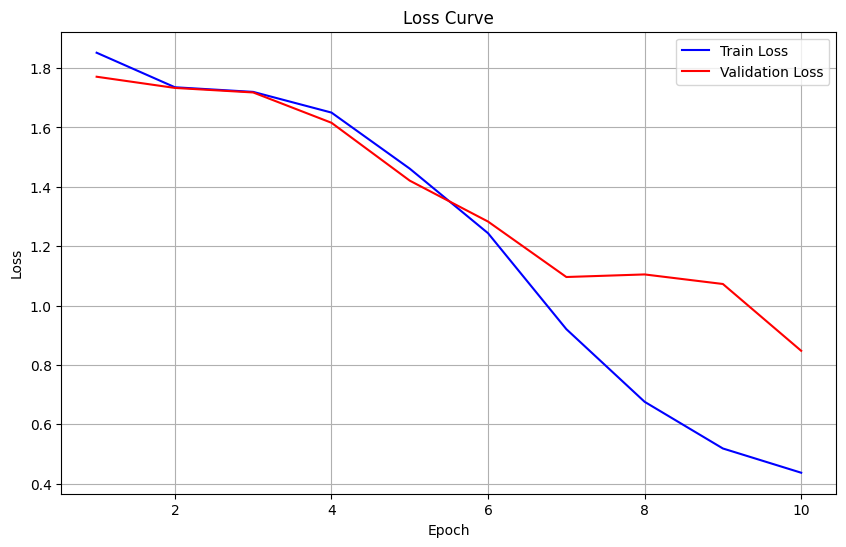

In [9]:
from transformers import AdamW

# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-5)

# Mode entraînement
model.train()

# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 10

# Boucle d'entraînement
for epoch in range(nb_epoch):
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        
        # Propagation avant (forward pass)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        # La perte est automatiquement calculée par le modèle avec CrossEntropyLoss
        loss = outputs.loss
        
        # Rétropropagation (backpropagation)
        loss.backward()
        
        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
        for batch in validation_dataloader:
            input_ids, attention_mask, labels = batch
            
            # Propagation avant (forward pass)
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            # La perte de validation
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    
    # Affichage de la perte de validation
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5 - Validation du modèle

Validation Loss: 0.8315357693604061


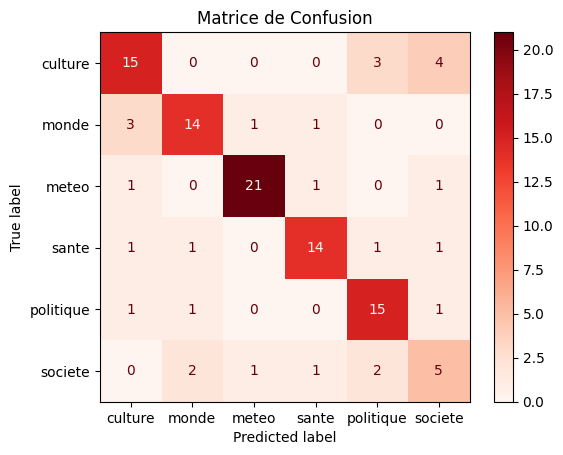

In [10]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_predictions = []
all_labels = []

test_loss = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
    test_loss += outputs.loss.item()

    predictions = torch.argmax(outputs.logits, dim=1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_dataloader)
print(f"Validation Loss: {test_loss}")

all_labels_name= [inv_label_map[x] for x in all_labels]
all_predictions_name = [inv_label_map[x] for x in all_predictions]

# Matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_label_map[i] for i in range(6)])
display.plot(cmap=plt.cm.Reds)
plt.title("Matrice de Confusion")
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

def calculate_metrics(labels, predictions):
    metrics = {}
    metrics['accuracy'] = accuracy_score(labels, predictions)
    metrics['precision'] = precision_score(labels, predictions, average='weighted')
    metrics['recall'] = recall_score(labels, predictions, average='weighted')
    metrics['f0.5_score'] = fbeta_score(labels, predictions, beta=0.5, average='weighted')
    metrics['f2_score'] = fbeta_score(labels, predictions, beta=2, average='weighted')
    metrics['f1_score'] = fbeta_score(labels, predictions, beta=1, average='weighted')
    
    return metrics

In [ ]:

def calculate_classwise_metrics(labels, predictions):
    
    metrics_per_class = {}
    
    
    for class_index, class_name in inv_label_map_to_keep.items():
        class_labels = [1 if label == class_index else 0 for label in labels]
        class_predictions = [1 if pred == class_index else 0 for pred in predictions]
        
        metrics_per_class[class_name] = {
            'accuracy': accuracy_score(class_labels, class_predictions),
            'precision': precision_score(class_labels, class_predictions, zero_division=0),
            'recall': recall_score(class_labels, class_predictions, zero_division=0),
            'f1_score': fbeta_score(class_labels, class_predictions, beta=1, zero_division=0),
            'f0.5_score': fbeta_score(class_labels, class_predictions, beta=0.5, zero_division=0),
            'f2_score': fbeta_score(class_labels, class_predictions, beta=2, zero_division=0)
        }
    
    return metrics_per_class

def display_classwise_metrics(metrics_per_class):
    
    class_names = list(metrics_per_class.keys())
    metric_names = ['accuracy','precision', 'recall', 'f1_score', 'f0.5_score', 'f2_score']
    
    donnees = np.array([[metrics_per_class[cls][metric] for metric in metric_names] for cls in class_names])
    num_classes, num_metrics = donnees.shape
    
    x = np.arange(num_metrics) 
    width = 0.15 
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i in range(num_classes):
        ax.bar(x + i * width, donnees[i], width, label=class_names[i])
    
    ax.set_title("Métriques par Classe", fontsize=16)
    ax.set_xticks(x + width * (num_classes - 1) / 2)
    ax.set_xticklabels(metric_names, fontsize=12)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_ylim(0, 1)  
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


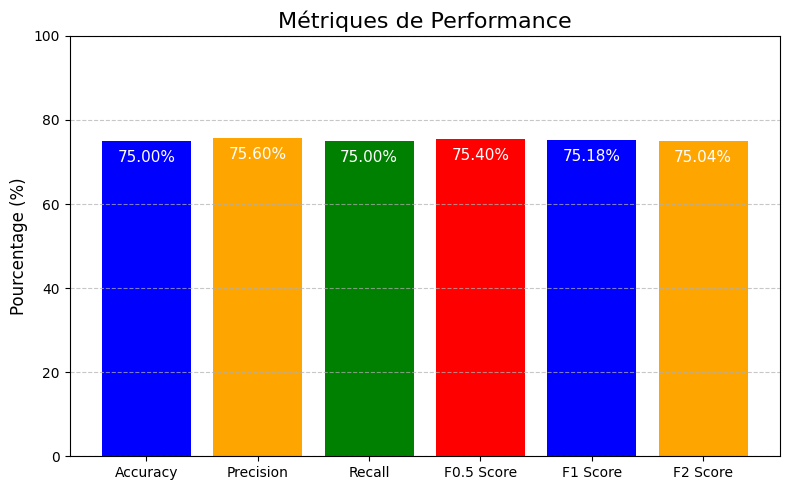

In [24]:
metrics = calculate_metrics(all_labels, all_predictions)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F0.5 Score', 'F1 Score', 'F2 Score']
metric_values = [
    metrics['accuracy'] * 100,
    metrics['precision'] * 100,
    metrics['recall'] * 100,
    metrics['f0.5_score'] * 100,
    metrics['f1_score'] * 100,
    metrics['f2_score'] * 100
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red'])
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,
             f"{value:.2f}%", ha='center', color='white', fontsize=11)

plt.title("Métriques de Performance", fontsize=16)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


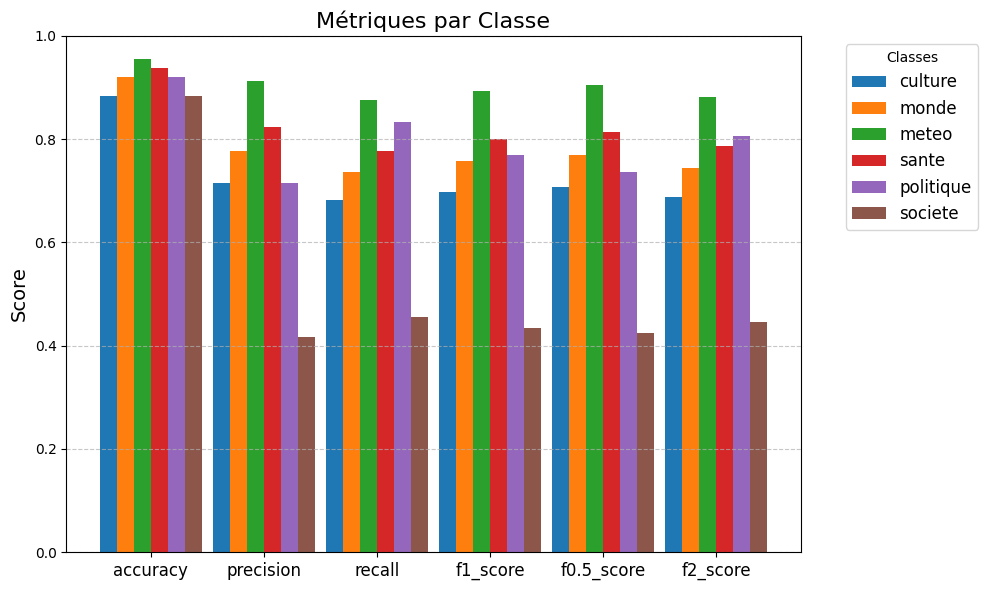

In [31]:
display_classwise_metrics(calculate_classwise_metrics(all_labels, all_predictions))

In [14]:
# # Mode évaluation
# model.eval()

# # Boucle de validation
# val_loss = 0
# for batch in validation_dataloader:
#     input_ids, attention_mask, labels = batch

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, 
#                         attention_mask=attention_mask, 
#                         labels=labels)
        
#     # La perte pour la validation
#     val_loss += outputs.loss.item()

#     prediction = torch.argmax(outputs.logits, dim=1)
#     print( "prediction", prediction[0].item(), "label" ,labels[0].item())
# val_loss = val_loss / len(validation_dataloader)
# print(f"Validation Loss: {val_loss}")